# Death predictor

Read in data from CSV, infer death from 3 mice in the dataset, and remove the two mice from cage 4 with unknown IDs.

In [8]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from aging.plotting import save_factory, figure, legend, format_plots, PlotConfig

In [32]:
format_plots()
saver = save_factory(PlotConfig().save_path / "fig5-death-predictor", tight_layout=False)

In [49]:
df = pd.read_parquet('/n/scratch/users/w/wg41/bio-age-model/longtogeny-behavioral-age-subset.parquet')
df_reset = df.reset_index()
df_reset.index = df_reset.index.rename('index')
df_reset.columns = df_reset.columns.rename('')

In [50]:
df_reset.groupby('mouse').last()[['date', 'beh_age', 'age']].sort_values(by='date')

,date,beh_age,age
mouse,,,
03_03,2021-10-16 17:00:57,37.344223,31.571428
02_04,2022-04-08 17:54:41,53.171543,56.428570
01_04,2022-07-10 15:40:44,48.481964,69.714287
01_03,2022-07-10 15:41:02,53.611191,69.714287
01_02,2022-07-10 15:41:15,57.274925,69.714287
01_01,2022-07-10 15:41:33,49.068161,69.714287
02_03,2022-07-10 16:06:48,59.473160,69.714287
02_02,2022-07-10 16:06:55,52.585346,69.714287
02_01,2022-07-10 16:07:01,47.895767,69.714287


In [13]:
death_df = pd.read_csv('death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [14]:
# death_map['fast'] = death_map['death_rank'] >= (len(death_map) // 2)

In [15]:
# necessary
# bins, _bins = pd.cut(df_reset['age'], 21, labels=False, retbins=True) < 1%
bins, _bins = pd.cut(df_reset['age'], 28, labels=False, retbins=True)

In [16]:
def bin_age(df, bins):
    return pd.cut(df['age'], bins, labels=False)


def compute_correlations(df, bins, death_map, group_size=3):
    corrs = []
    for i in range(group_size):
        for bin, _df in df.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()


def compute_shuffled_correlations(df, bins, death_map, group_size=3, seed=None):
    df_copy = df.copy()
    death_map = death_map.copy()
    # death_map['Death'] = death_map['Death'].sample(frac=1, random_state=seed).to_numpy()
    # death_map['death_rank'] = death_map['death_rank'].sample(frac=1, random_state=seed).to_numpy()

    corrs = []
    for i in range(group_size):
        # shuffling happens here
        df_copy['beh_age'] = df.groupby((bins + i) // group_size, observed=True)['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())
        # df_copy['beh_age'] = df['beh_age'].sample(frac=1, random_state=seed).to_numpy()
        # df_copy['beh_age'] = df.groupby('mouse')['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())

        for bin, _df in df_copy.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()

In [17]:
corrs = compute_correlations(df_reset, bin_age(df_reset, _bins), death_map, group_size=4)

In [25]:
n_shuff = 1_000

rng = np.random.RandomState(0)

shuff_corrs = []
for i in tqdm(range(n_shuff)):
    _shuff_corrs = compute_shuffled_correlations(df_reset, bin_age(df_reset, _bins), death_map, seed=rng, group_size=4)
    _shuff_corrs['shuffle'] = i
    shuff_corrs.append(_shuff_corrs)

shuff_corrs = pd.concat(shuff_corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
for age, _df in shuff_corrs.groupby('age'):
    continue

In [27]:
(_df['Death'] < corrs.loc[age, 'Death']).mean()

0.009

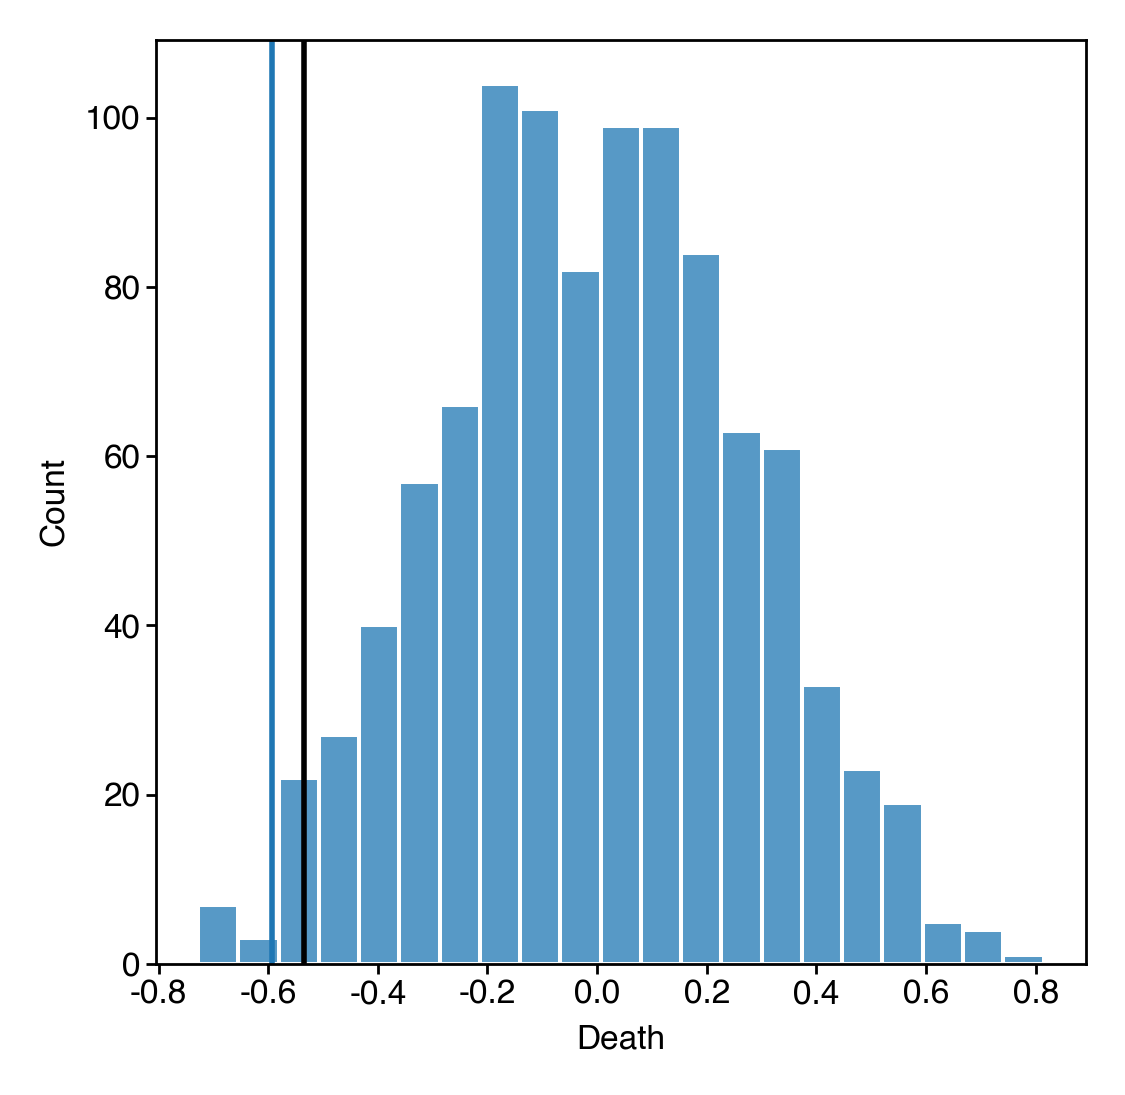

In [166]:
ax = sns.histplot(_df['Death'])
ax.axvline(-_df['Death'].std() * 1.95, color='k')
ax.axvline(corrs.loc[age, 'Death'])

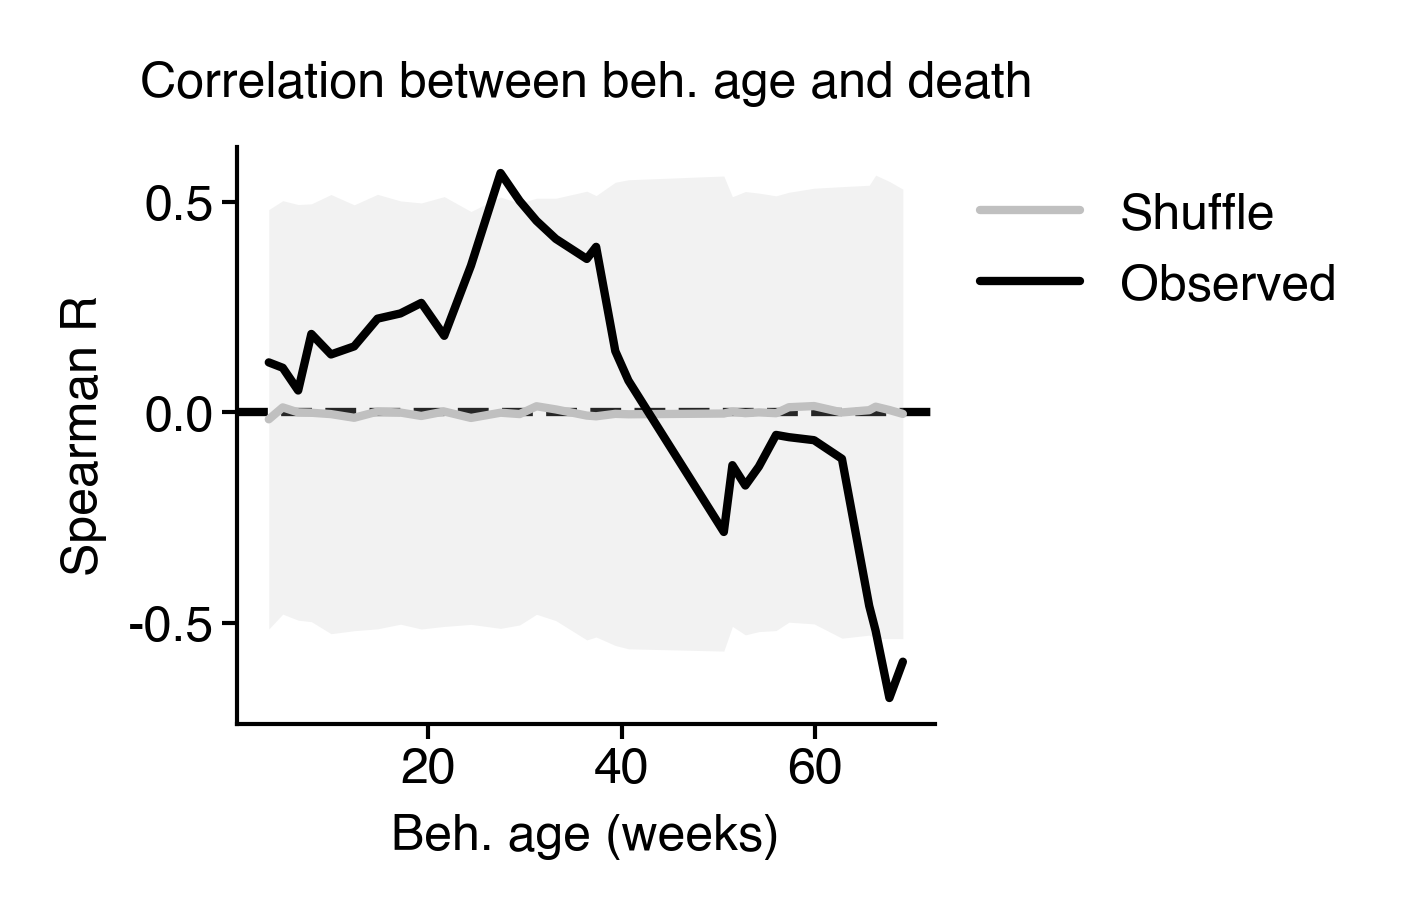

In [150]:
fig = figure(1.5, 1.25)
ax = sns.lineplot(
    data=shuff_corrs.reset_index(),
    x="age",
    y="Death",
    errorbar=("sd", 1.95),
    err_kws=dict(lw=0),
    color="silver",
    label="Shuffle",
)
ax = corrs.sort_index()["Death"].plot(color="k", label="Observed")

ax.axhline(0, color="k", ls="--", zorder=-1)
ax.set(
    ylabel="Spearman R",
    xlabel="Beh. age (weeks)",
    title="Correlation between beh. age and death",
)
legend()
sns.despine()
saver(fig, "death-correlations");

## Pull out an example

In [70]:
def compute_examples(df, bins, death_map, group_size=3):
    examples = []
    for i in range(group_size):
        out = {}
        for bin, _df in df.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)

            out[bin]= joined
        examples.append(out)
    return examples

In [122]:
examples = compute_examples(df_reset, bin_age(df_reset, _bins), death_map, group_size=4)

In [123]:
list(examples[0])

[0, 1, 2, 3, 4, 5, 6]

In [158]:
example = examples[0][6]
example.corr(method='spearman').loc[['Death', 'beh_age'], ['Death', 'beh_age']]

,Death,beh_age
Death,1.000000,-0.460187
beh_age,-0.460187,1.000000


In [159]:
example = example[example['Death'] > pd.to_datetime('2022-08')]

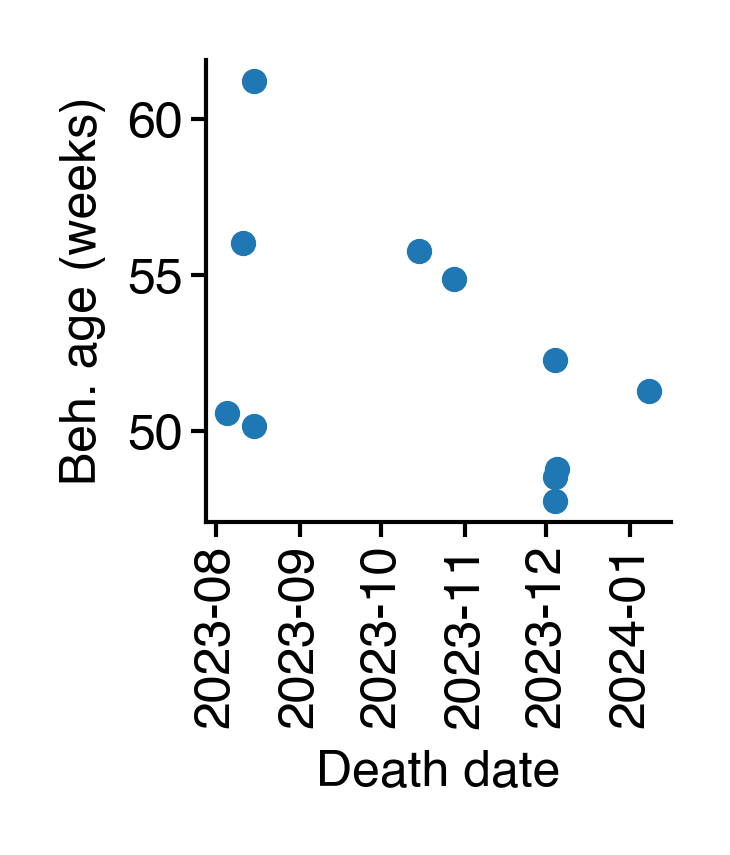

In [148]:
fig = figure(1, 1)
plt.scatter(example['Death'], example['beh_age'], s=5)
plt.xlabel("Death date")
plt.ylabel("Beh. age (weeks)")
plt.xticks(rotation=90)
sns.despine()

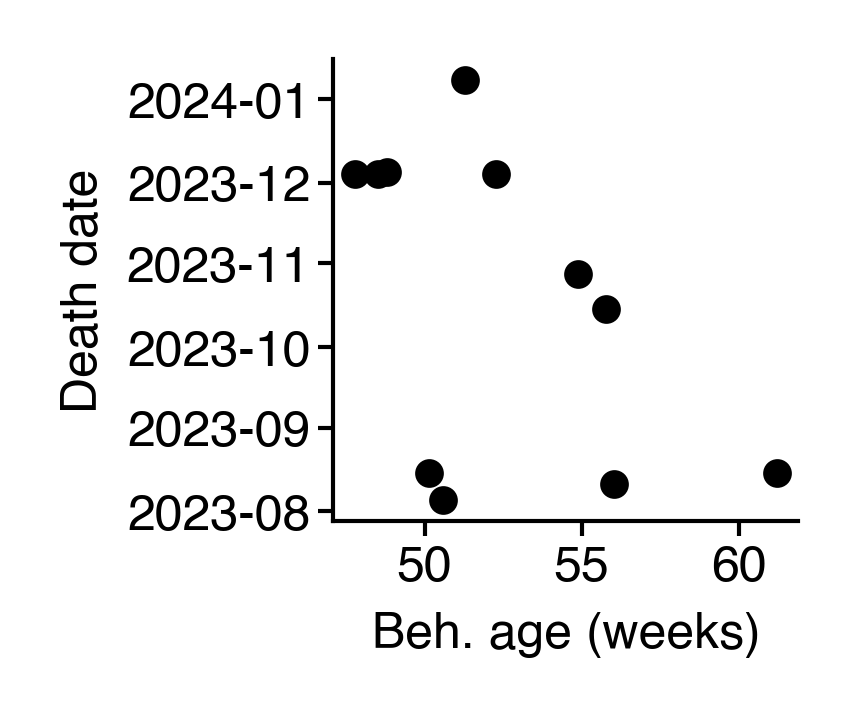

In [161]:
fig = figure(1, 1)
plt.scatter(example['beh_age'], example['Death'], s=7, c='k')
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Death date")
# plt.xticks(rotation=90)
sns.despine()
saver(fig, "example-death-beh-age-relationship");

In [163]:
example = examples[0][2]
example.corr(method='spearman').loc[['Death', 'beh_age'], ['Death', 'beh_age']]

,Death,beh_age
Death,1.000000,0.568691
beh_age,0.568691,1.000000


In [164]:
example = example[example['beh_age'] > 20]

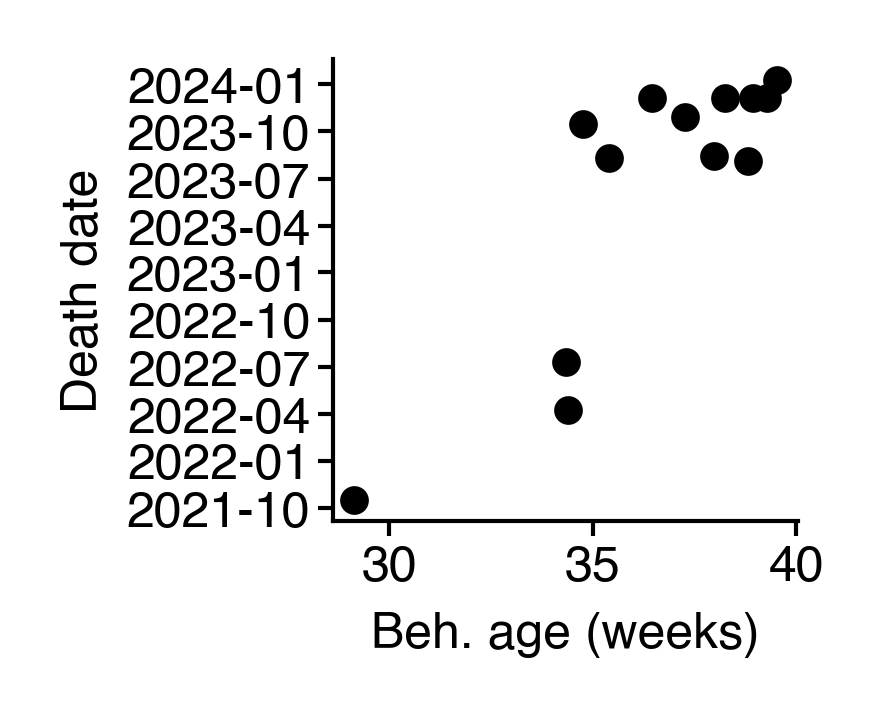

In [165]:
fig = figure(1, 1)
plt.scatter(example['beh_age'], example['Death'], s=7, c='k')
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Death date")
# plt.xticks(rotation=90)
sns.despine()
saver(fig, "example-young-age-death-beh-age-relationship");